# Load

In [1]:
import pandas as pd

In [2]:
fuel_consumption = pd.read_csv('overall jet fuel 2008-2016.csv', header=None, names=['ts', 'fuel_consumption'])

In [3]:
fuel_consumption.head()

,ts,fuel_consumption
0,2008-05-24,320001.000000
1,2008-05-25,320001.826375
2,2008-05-26,320002.969334
3,2008-05-27,320003.513974
4,2008-05-28,320004.112301


# Transformations

In [4]:
fuel_consumption.ts = pd.to_datetime(fuel_consumption.ts, format='%Y-%m-%d')

# Exploration

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

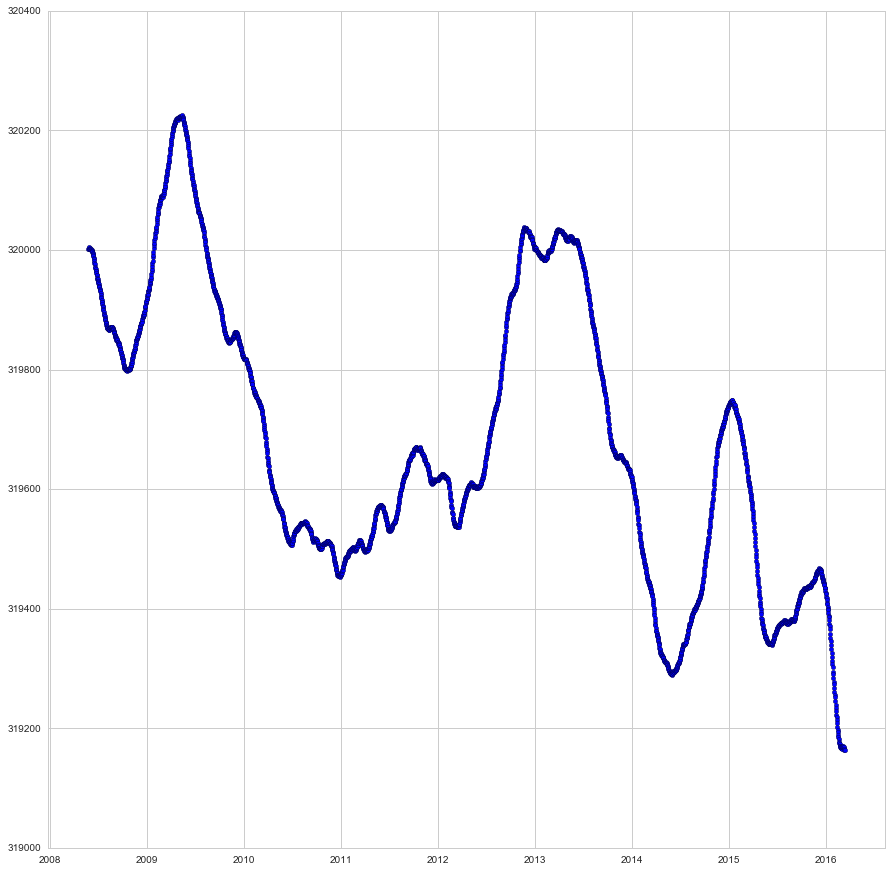

In [11]:
plt.figure(figsize=(15,15))
plt.scatter(fuel_consumption.ts.tolist(), fuel_consumption.fuel_consumption.tolist())
plt.show()

In [12]:
sorted_fc = fuel_consumption.sort_values(by='ts')

In [13]:
fuel_diff = (sorted_fc.shift(1) - sorted_fc).dropna()

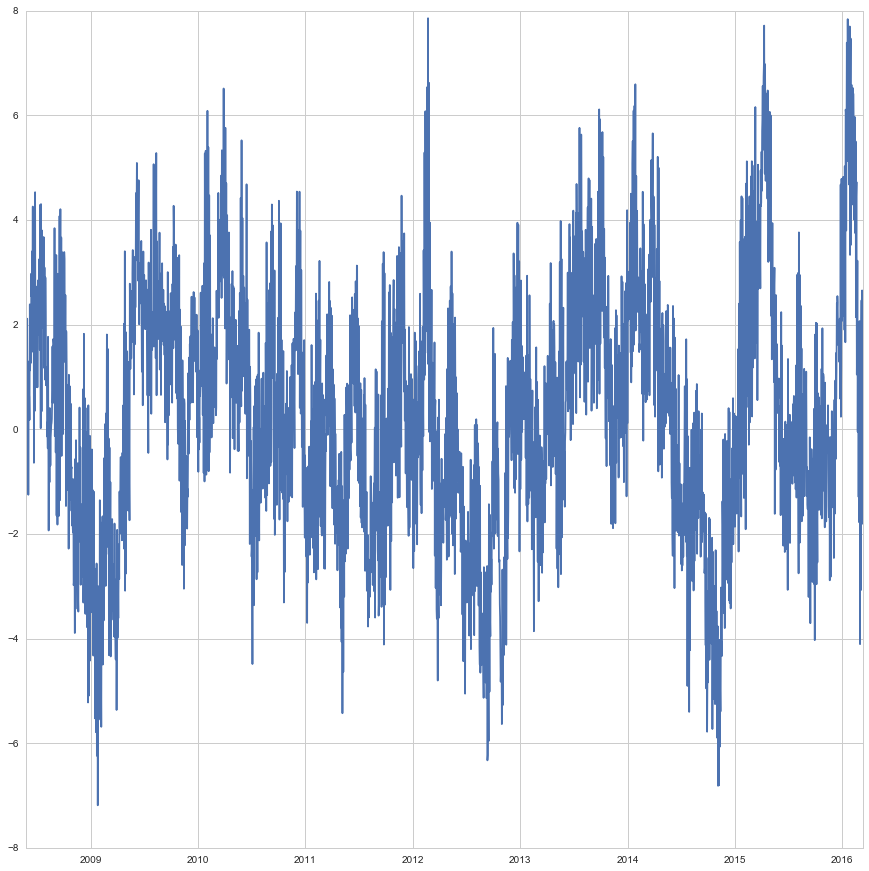

In [14]:
plt.figure(figsize=(15,15))
plt.plot(sorted_fc.ts.tolist()[1:], fuel_diff.fuel_consumption.tolist())

In [15]:
window= 200
fuel_consumption['rol_mean'] = fuel_consumption.fuel_consumption.rolling(window=window).mean()
fuel_consumption['rol_med'] = fuel_consumption.fuel_consumption.rolling(window=window).median()
fuel_consumption['rol_std'] = fuel_consumption.fuel_consumption.rolling(window=window).std()

In [16]:
fuel_consumption.head()

,ts,fuel_consumption,rol_mean,rol_med,rol_std
0,2008-05-24,320001.000000,NaN,NaN,NaN
1,2008-05-25,320001.826375,NaN,NaN,NaN
2,2008-05-26,320002.969334,NaN,NaN,NaN
3,2008-05-27,320003.513974,NaN,NaN,NaN
4,2008-05-28,320004.112301,NaN,NaN,NaN


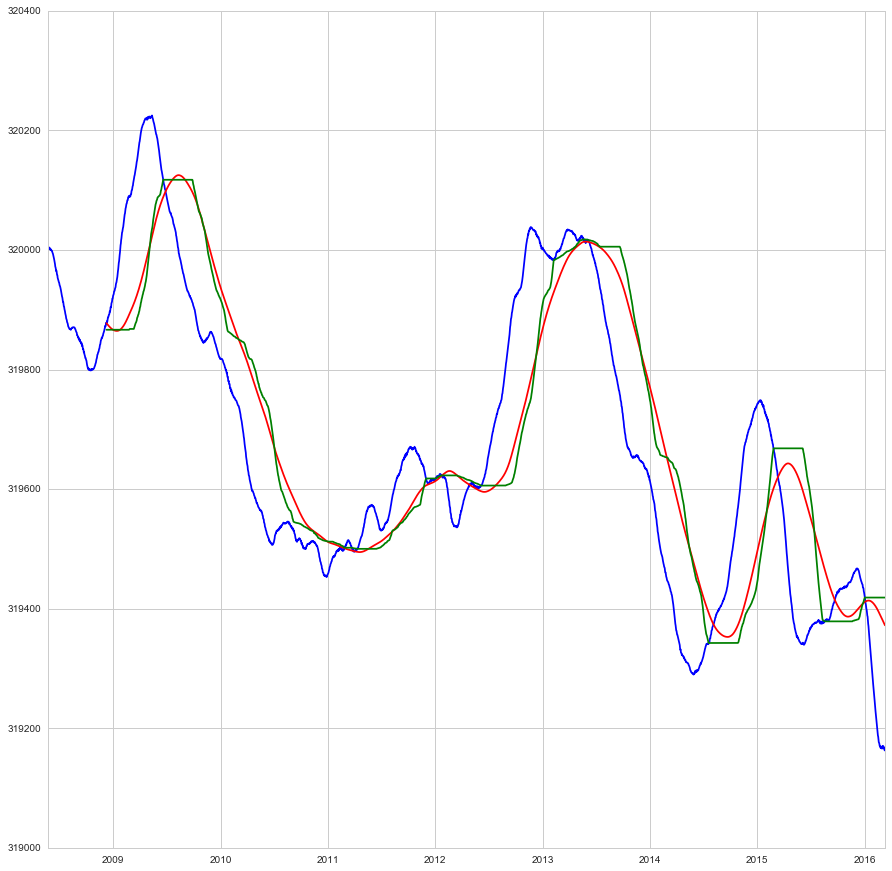

In [17]:
plt.figure(figsize=(15,15))
plt.plot(fuel_consumption.ts.tolist(), fuel_consumption.fuel_consumption.tolist(), color='b')
plt.plot(fuel_consumption.ts[window-1:], fuel_consumption.rol_mean[window-1:], color='r')
plt.plot(fuel_consumption.ts[window-1:], fuel_consumption.rol_med[window-1:], color='g')
# plt.plot(fuel_consumption.ts[window-1:], fuel_consumption.rol_std[window-1:], color='y')

In [18]:
window= 200
fuel_diff['rol_mean'] = fuel_diff.fuel_consumption.rolling(window=window).mean()
fuel_diff['rol_med'] = fuel_diff.fuel_consumption.rolling(window=window).median()
fuel_diff['rol_std'] = fuel_diff.fuel_consumption.rolling(window=window).std()

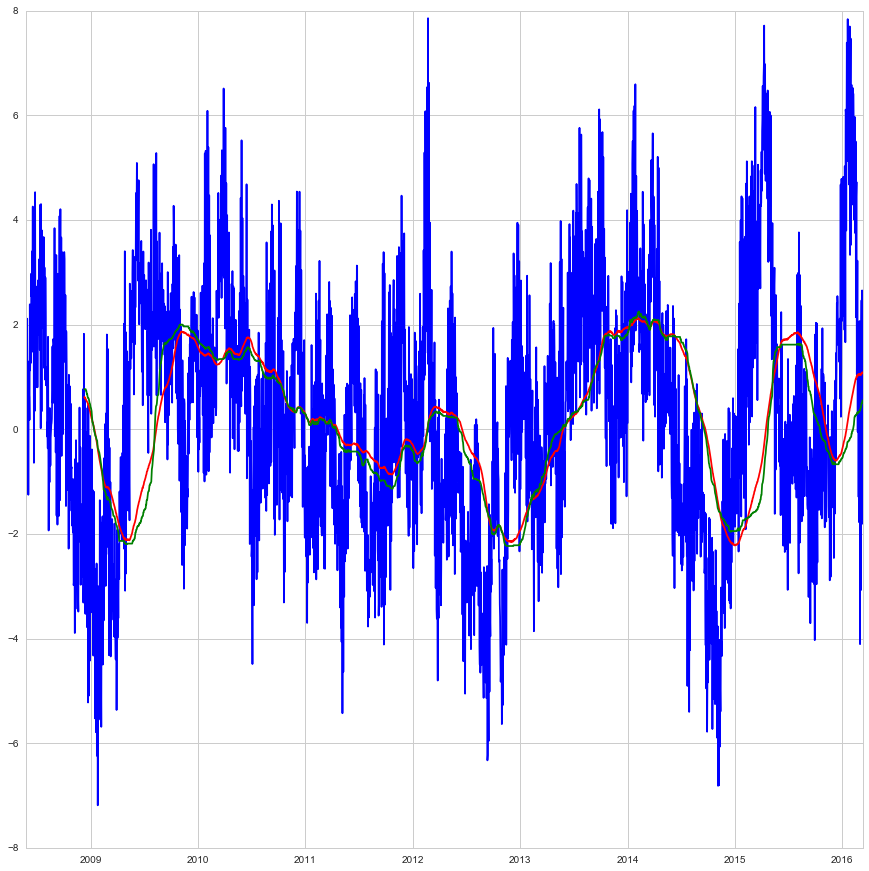

In [19]:
plt.figure(figsize=(15,15))
plt.plot(sorted_fc.ts.tolist()[1:], fuel_diff.fuel_consumption.tolist(), color='b')
plt.plot(sorted_fc.ts[window:], fuel_diff.rol_mean[window-1:], color='r')
plt.plot(sorted_fc.ts[window:], fuel_diff.rol_med[window-1:], color='g')

# stationarity test 

In [20]:
from statsmodels.tsa.stattools import adfuller

fuel consumption

In [21]:
dftest = adfuller(fuel_consumption[['ts', 'fuel_consumption']].set_index('ts')['fuel_consumption'])
result = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '#lags used', '# of observations'])
for k, v in dftest[4].items():
    result['critical value (%s)'%k] = v
print result

test statistic            -2.272371
p-value                    0.181034
#lags used                 4.000000
# of observations       2843.000000
critical value (5%)       -2.862557
critical value (1%)       -3.432652
critical value (10%)      -2.567311
dtype: float64


fuel consumption diff

In [22]:
dftest = adfuller(fuel_diff[['ts', 'fuel_consumption']].set_index('ts')['fuel_consumption'])
result = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '#lags used', '# of observations'])
for k, v in dftest[4].items():
    result['critical value (%s)'%k] = v
print result

test statistic            -4.802629
p-value                    0.000054
#lags used                 3.000000
# of observations       2843.000000
critical value (5%)       -2.862557
critical value (1%)       -3.432652
critical value (10%)      -2.567311
dtype: float64


### seasonal decompose

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
decompose = seasonal_decompose(fuel_consumption[['ts', 'fuel_consumption']].set_index('ts')['fuel_consumption'].tolist(), freq=2)

C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


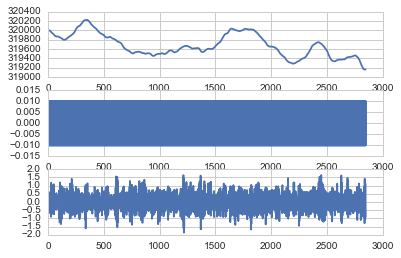

In [25]:
plt.subplot(311)
plt.plot(decompose.trend)
plt.subplot(312)
plt.plot(decompose.seasonal)
plt.subplot(313)
plt.plot(decompose.resid)

In [26]:
decompose = seasonal_decompose(fuel_diff['fuel_consumption'].tolist(), freq=1)

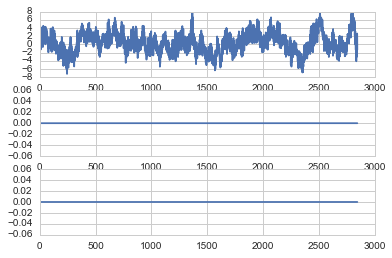

In [27]:
plt.subplot(311)
plt.plot(decompose.trend)
plt.subplot(312)
plt.plot(decompose.seasonal)
plt.subplot(313)
plt.plot(decompose.resid)

### ACF, PACF

In [28]:
from statsmodels.tsa.stattools import acf, pacf

In [29]:
fuel_diff_series = pd.Series(fuel_diff['fuel_consumption'].values, index=fuel_consumption['ts'][1:])

In [30]:
lag_acf = acf(fuel_diff_series, nlags=20)

In [31]:
lag_pacf = pacf(fuel_diff_series, nlags=20)

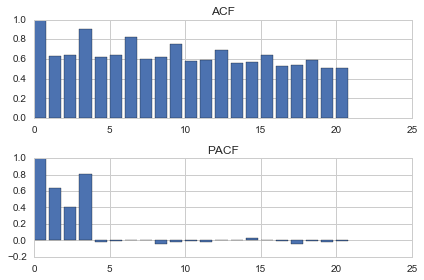

In [32]:
plt.subplot(2,1,1)
plt.title('ACF')
plt.bar(range(len(lag_acf)), lag_acf.tolist())
plt.subplot(2,1,2)
plt.title('PACF')
plt.bar(range(len(lag_pacf)), lag_pacf.tolist())
plt.tight_layout()

### finding p, q, d that minimizes aic / bic using gridsearch

#### Setting

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train_size = int(.95 * fuel_diff_series.size)
test_size = fuel_diff_series.size - train_size

In [35]:
train_set = fuel_diff_series.iloc[0:train_size]
test_set = fuel_diff_series.iloc[train_size:]

#### Optimize

In [31]:
from statsmodels.tsa.arima_model import ARIMA
from scipy.optimize import brute, fmin
import numpy as np

In [32]:
def arima_aic(order):
    try:
        model = ARIMA(train_set, order=order)
        results_AR = model.fit()
        return results_AR.aic
    except ValueError as e:
        return np.inf
    
order_ranges = (slice(1,7,1), slice(0,2,1), slice(1,7,1))
res = brute(arima_aic, order_ranges, full_output=True, finish=None)
opt_order, fval, grid, jout = res
print opt_order

C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarn

[ 5.  0.  4.]


C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Learn

In [33]:
model = ARIMA(train_set, order=[int(val) for val in opt_order])
results_AR = model.fit()

C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


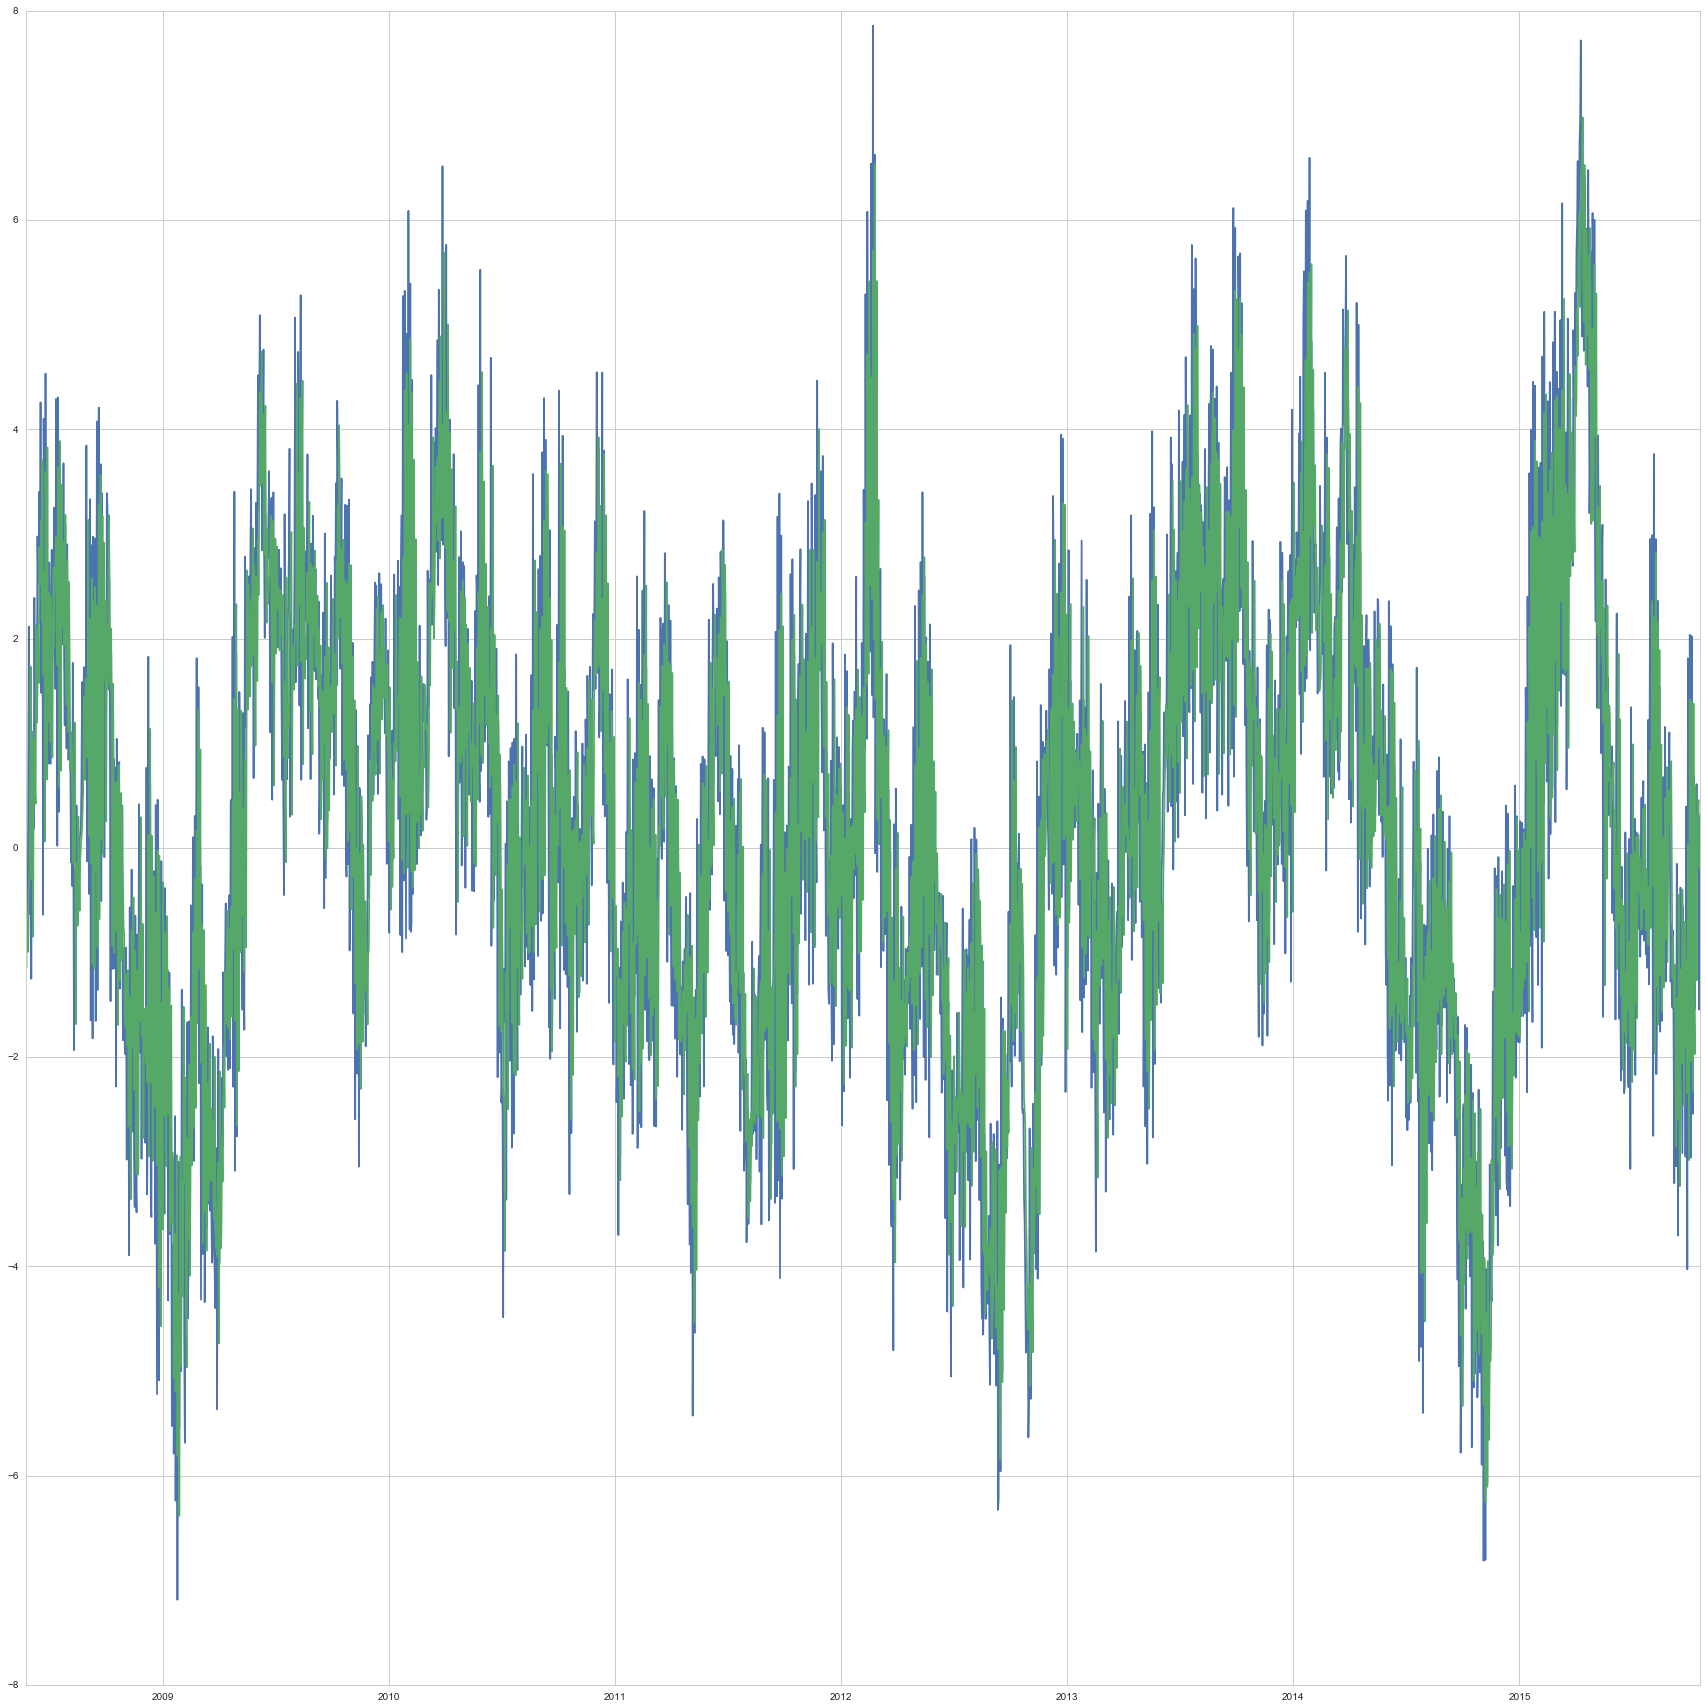

In [34]:
fig = plt.figure(figsize=(30,30))
plt.plot(train_set)
plt.plot(results_AR.fittedvalues)

# Predict

In [35]:
predictions_cum_sum = results_AR.predict(start=2700, end=3500, dynamic=False).cumsum()

C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


# Visualize 

visualization of the diff series 

In [36]:
from statsmodels.tsa.arima_model import ARMAResults

C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\tsa\arima_model.py:1724: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


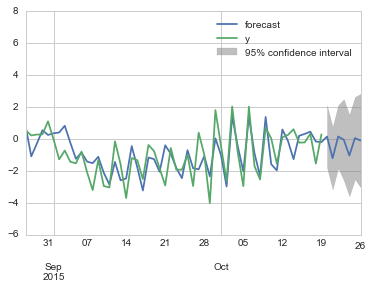

In [37]:
results_AR.plot_predict(start=2650, end=2710)
plt.plot(test_set, color='r')

visualization of the original series 

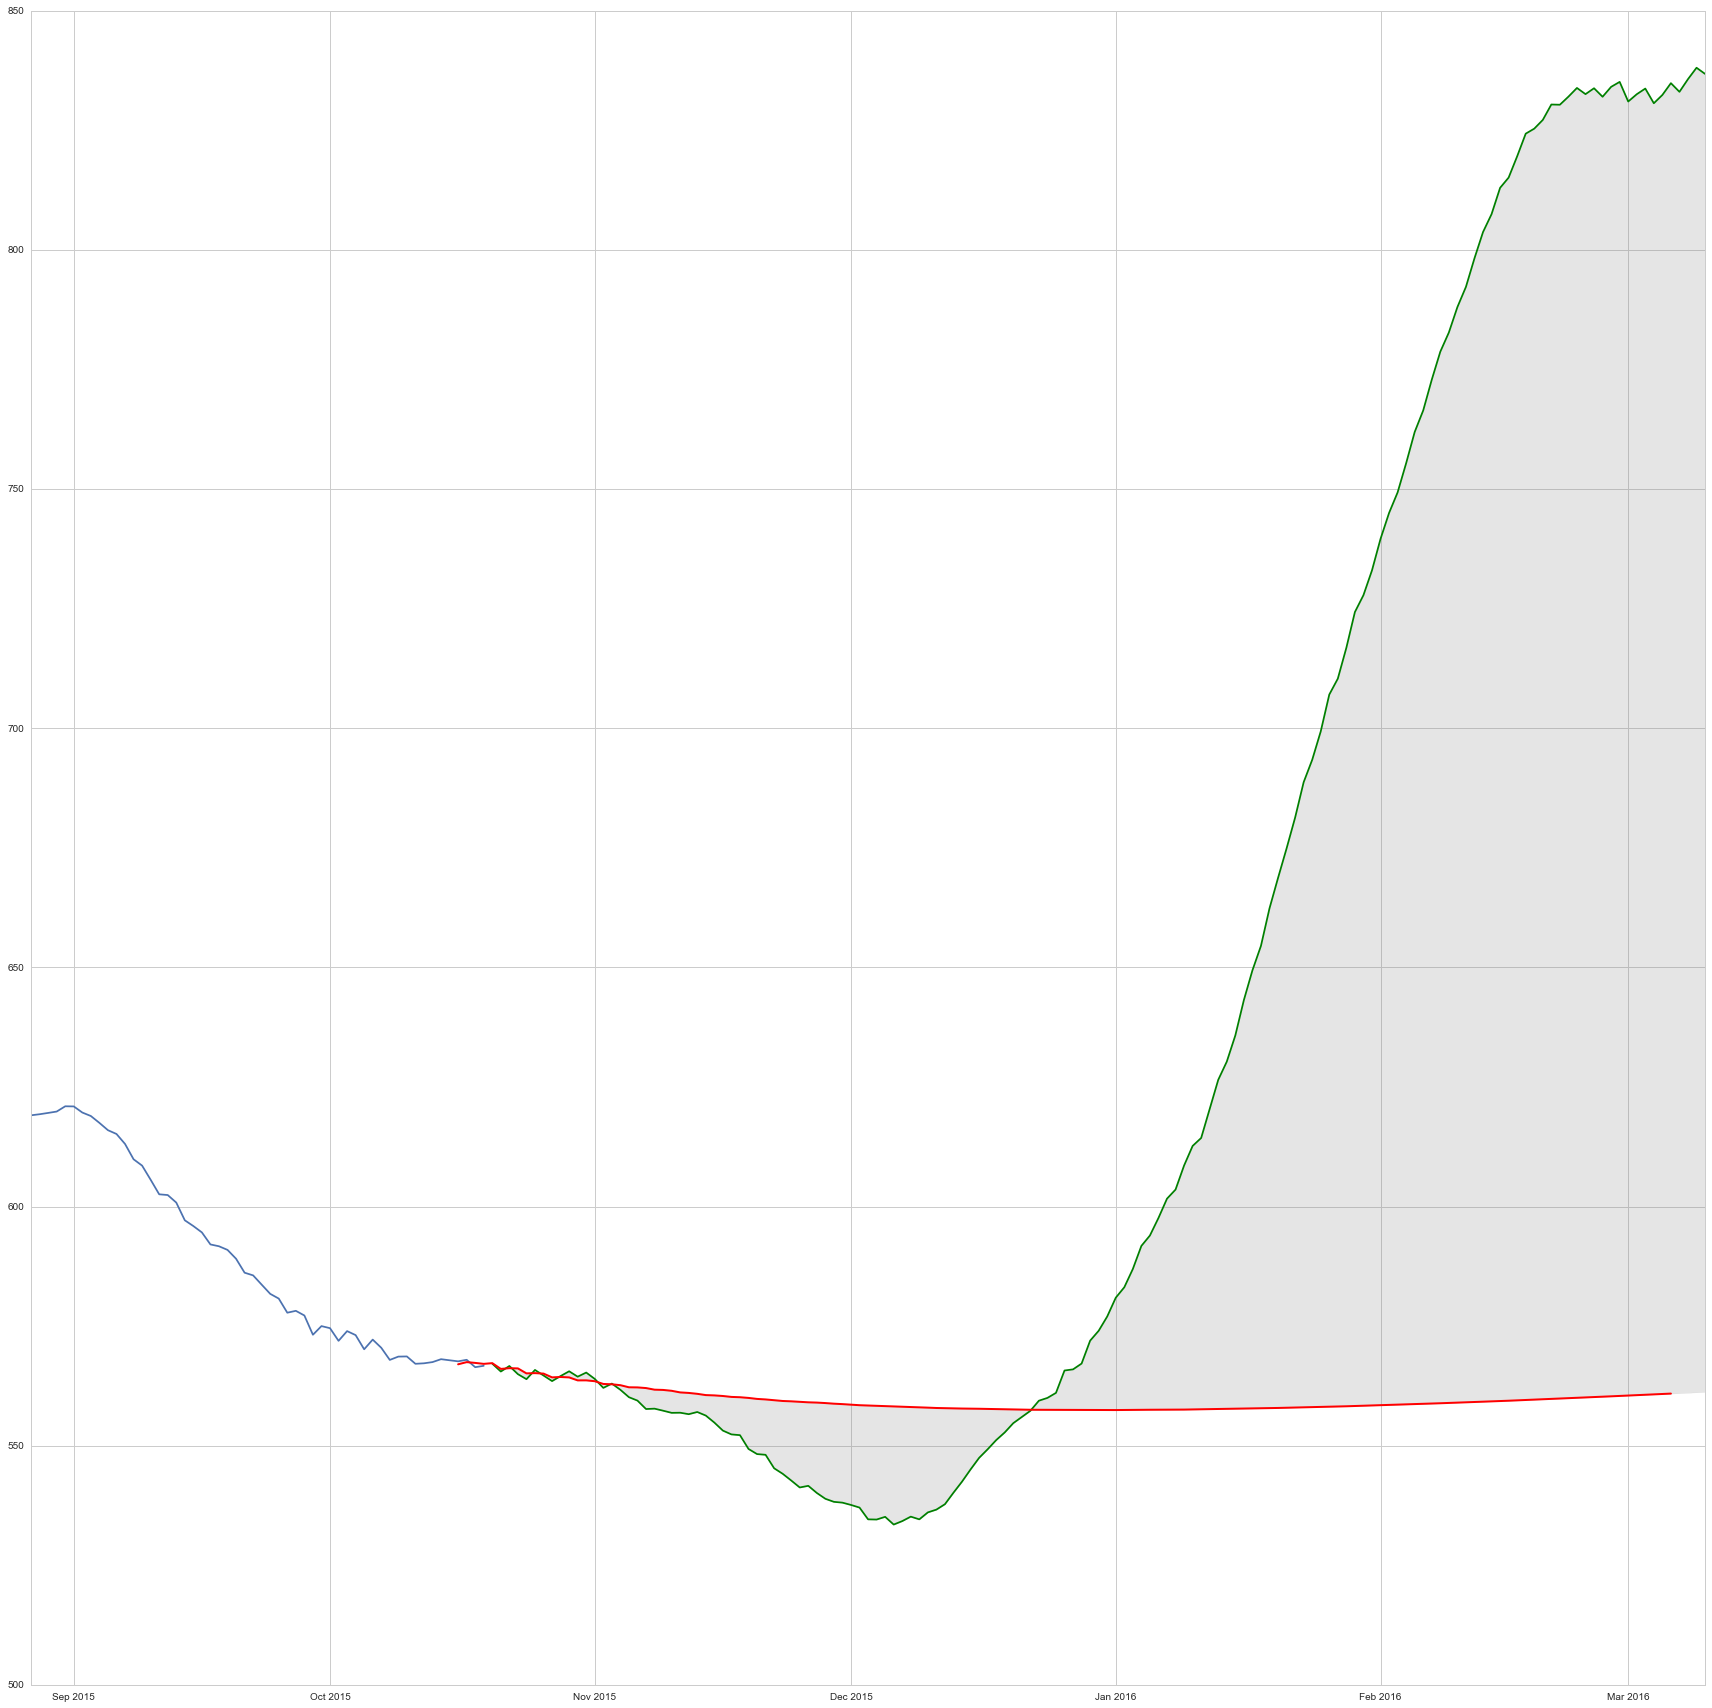

In [45]:
y = test_set.cumsum()+train_set.cumsum()[-1]
y_hat = predictions_cum_sum+train_set.cumsum()[-1]
plt.figure(figsize=(30,30))

# plot train_set
plt.plot(train_set.cumsum()[2650:])

# plot test_set
plt.plot(y, color='g')

# plot predictions
plt.plot(y_hat[:143], color='r', linewidth=2)

# plot error
plt.fill_between(y_hat.index, y[y_hat.index], y_hat, color='gray', alpha=0.2)

find max num of days we can predict given the constraint of max rmse = 1

In [39]:
from scipy.optimize import brute, fmin

y = test_set.cumsum()+train_set.cumsum()[-1]
y_hat = predictions_cum_sum+train_set.cumsum()[-1]
max_RMSE = 1

def dist_from_max_rmse(y_hat_n_days, y, y_hat, max_RMSE):
    y_hat = y_hat[y_hat.index[slice(0,y_hat_n_days,1)]]
    SE = ((y_hat - y)**2).dropna()
    if SE.size == 0:
        return np.inf
    MSE = SE.sum() / SE.size
    RMSE = MSE ** 0.5
    if RMSE > max_RMSE:
        return np.inf
    return max_RMSE - RMSE

y_hat_n_days_range = [slice(1,y_hat.size,1)]
max_n_days, min_max_rmse_dist, _, _ = brute(dist_from_max_rmse, y_hat_n_days_range, args=(y, y_hat, max_RMSE), full_output=True, finish=None)

In [40]:
max_n_days

21.0

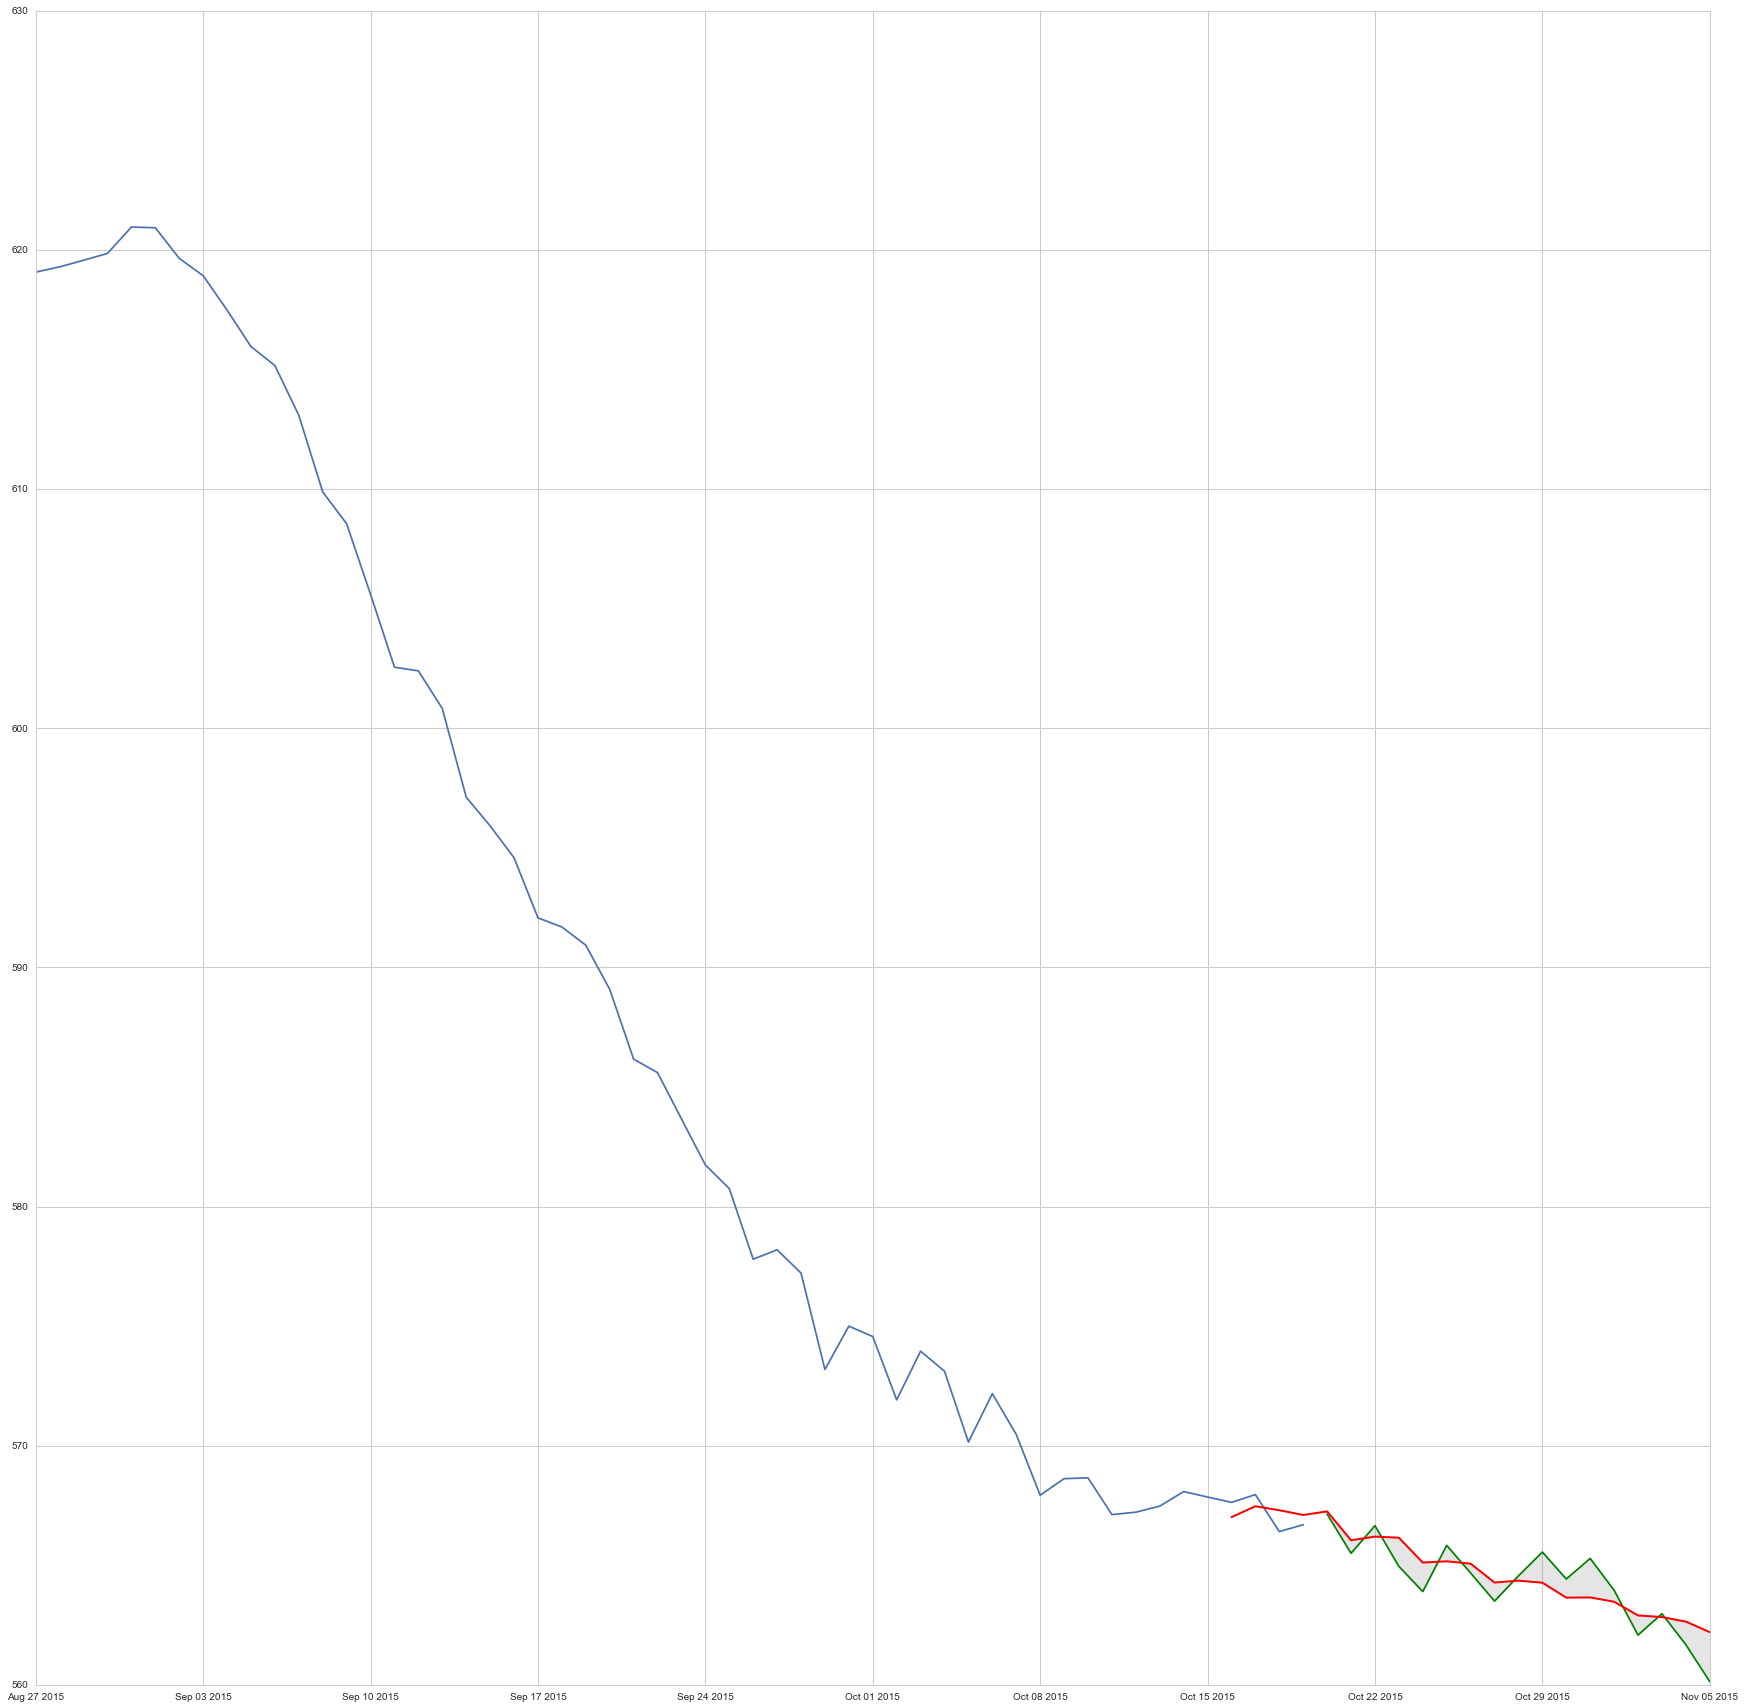

In [41]:
y = (test_set.cumsum()+train_set.cumsum()[-1])[:45]
y_hat = (predictions_cum_sum+train_set.cumsum()[-1])[:int(max_n_days)]
plt.figure(figsize=(30,30))

# plot train_set
plt.plot(train_set.cumsum()[2650:])

# plot test_set
plt.plot(y[y_hat.index], color='g')

# plot predictions
plt.plot(y_hat, color='r', linewidth=2)

# plot error
plt.fill_between(y_hat.index, y[y_hat.index], y_hat, color='gray', alpha=0.2)

# Evaluation

In [42]:
SE = ((y_hat - y)**2).dropna()
MSE = SE.sum() / SE.size
RMSE = MSE ** 0.5

print MSE, RMSE, 'for %s days ahead' % SE.size

0.924672114578 0.961598728461 for 17 days ahead


# Bonus

dynamic forcasting <br>
tried multithreading - did not show performance improvements <br>
tried optimizing order each iteration - redundant <br>
could be improved by finding the optimal train size

In [41]:
from statsmodels.tsa.arima_model import ARIMA
from scipy.optimize import brute, fmin
import numpy as np

def arima_aic(order, test_idx):
    try:
        model = ARIMA(train_set.append(test_set[:test_idx]), order=order)
        results_AR = model.fit()
        return results_AR.aic
    except ValueError as e:
        return np.inf

model = ARIMA(train_set, order=(5,0,4))
results_AR = model.fit()
predictions = results_AR.predict(start=train_set.size, end=train_set.size, dynamic=False)
for i in range(1, test_set.size):
    
    # learn
    model = ARIMA(train_set.append(test_set[test_set.index[:i]]), order=(5,0,4))
    results_AR = model.fit()
    
    # predict
    res = results_AR.predict(start=train_set.size+i, end=train_set.size+i, dynamic=False)
    predictions.set_value(res.index[0], res.values[0])

C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2 4.1.1\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarn

LinAlgError: SVD did not converge

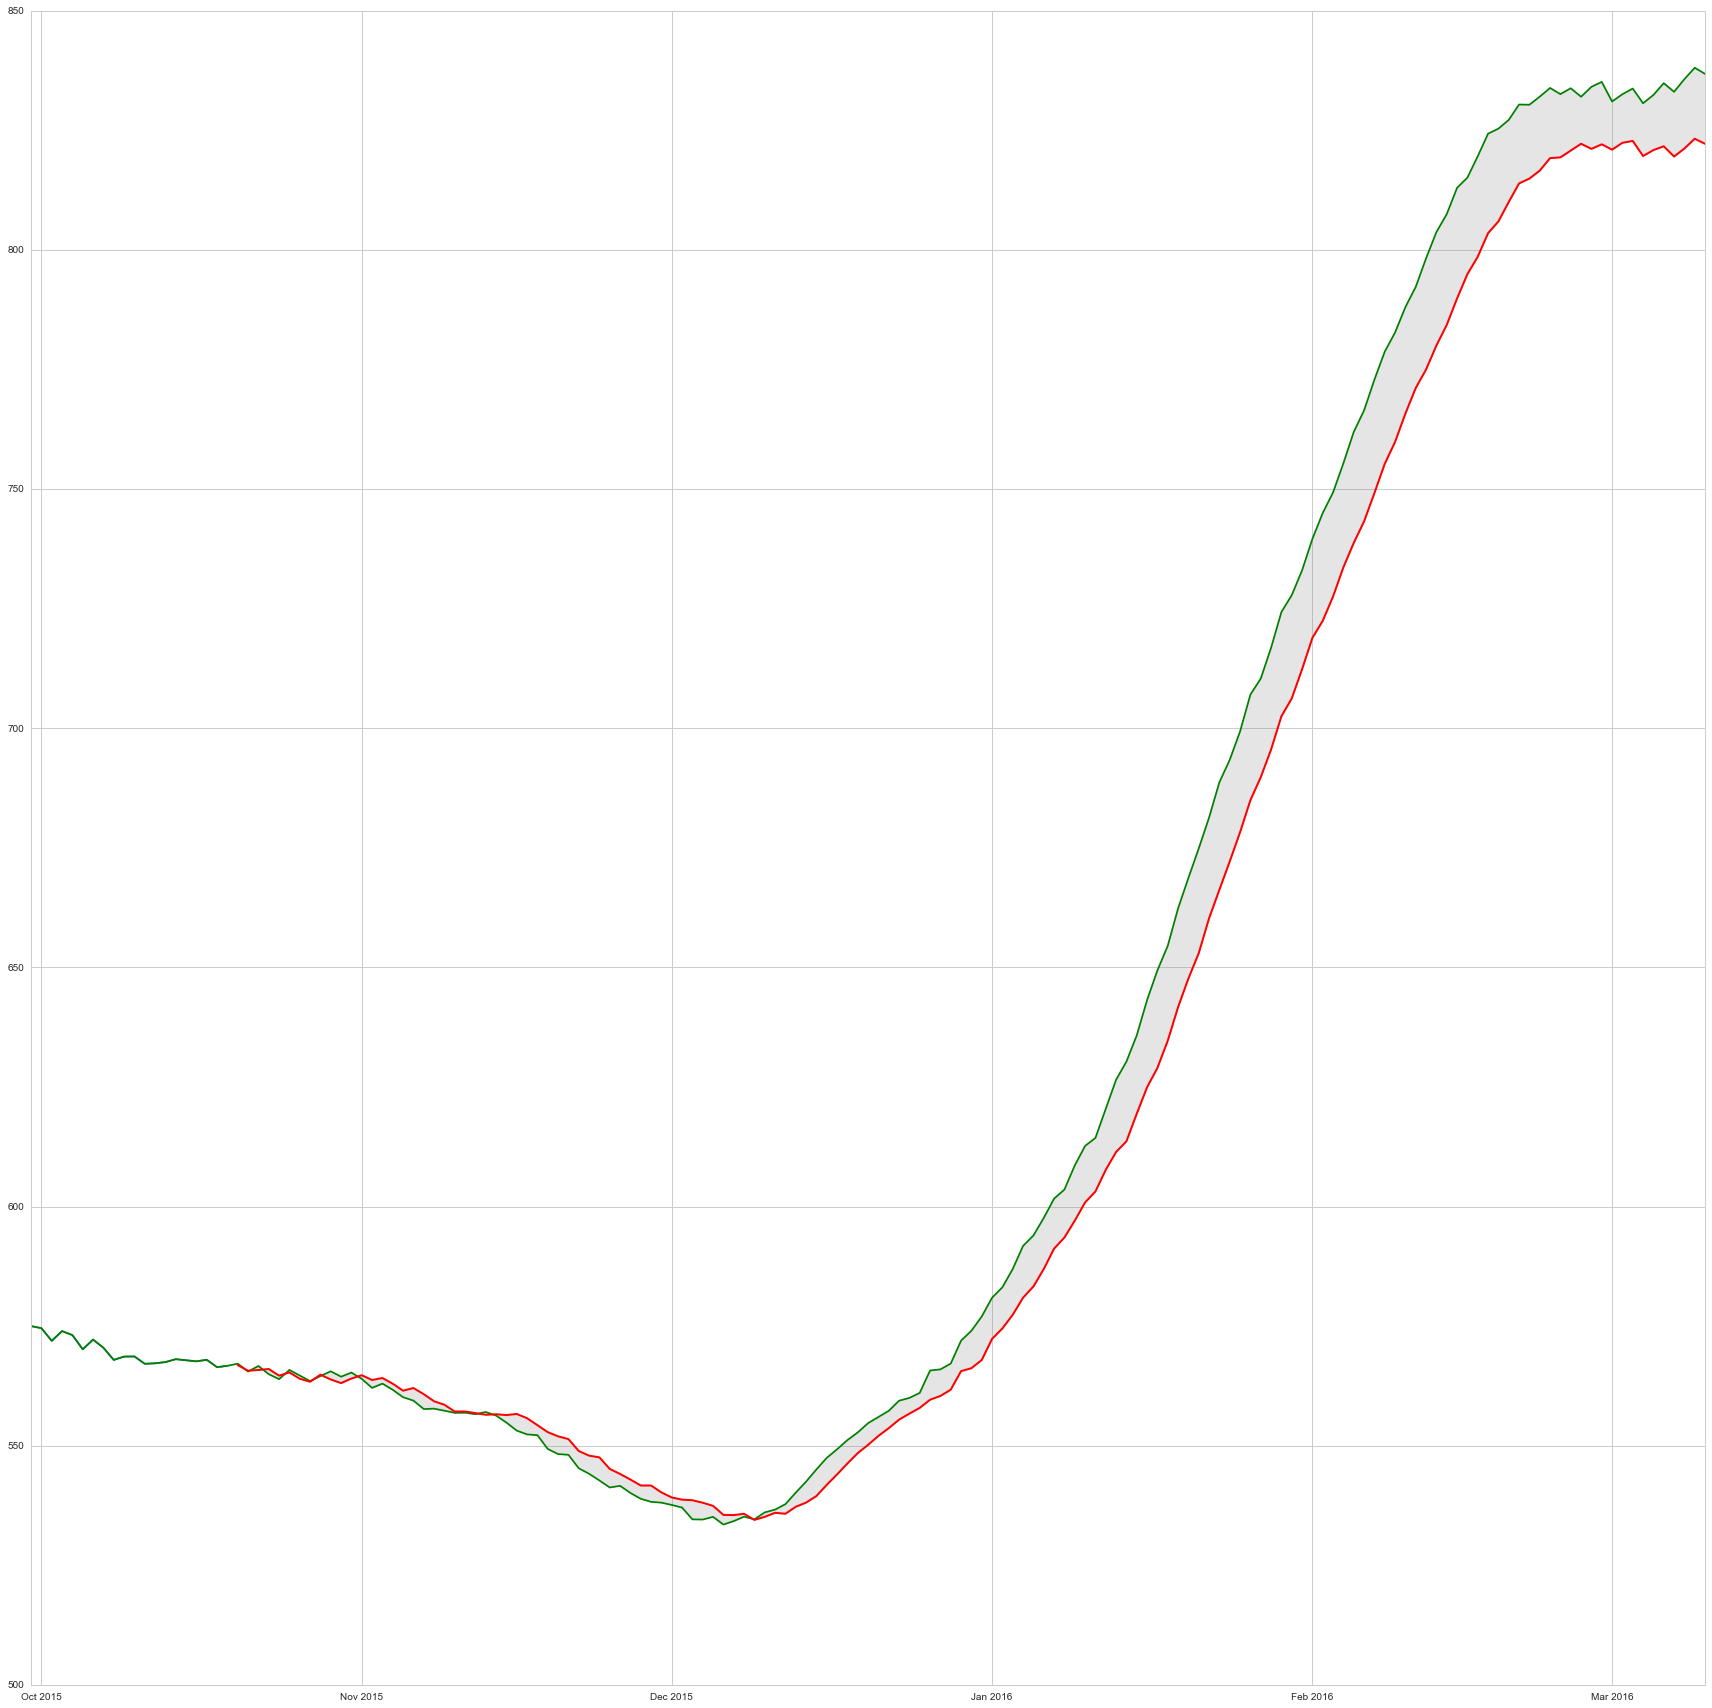

In [644]:
test_adjusted = test_set.cumsum()+ train_set.cumsum()[-1]
y = train_set.cumsum().append(test_adjusted)[train_set.size-20:train_set.size+test_set.size]
y_hat = predictions.cumsum()+train_set.cumsum()[-1]
plt.figure(figsize=(30,30))

# plot train_set
plt.plot(train_set.cumsum()[train_set.size-20:])

# plot test_set
plt.plot(y, color='g')

# plot predictions
plt.plot(y_hat, color='r', linewidth=2)

# plot error
plt.fill_between(y_hat.index, y[y_hat.index], y_hat, color='gray', alpha=0.2)

# Evaluation

In [45]:
SE = ((y_hat - y)**2).dropna()
MSE = SE.sum() / SE.size
RMSE = MSE ** 0.5

print MSE, RMSE

159.666440619 12.6359186694
